In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import scipy.signal as sps
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import DomainWarning
from filtered_point_process.model import Model
from filtered_point_process.point_processes.filtered_point_process import FilteredPointProcess
import os

In [2]:
# ─── PLOT STYLING ───────────────────────────────────────────────────
plt.rcParams.update({
    'font.size':          16,
    'axes.titlesize':     16,
    'axes.labelsize':     16,
    'xtick.labelsize':    14,
    'ytick.labelsize':    14,
    'legend.fontsize':    16,
    'figure.titlesize':   16,
})

# ─── PARAMETERS ────────────────────────────────────────────────────
FS           = 1000.0    # sampling rate (Hz)
DURATION     = 6.0       # total simulation time (s)
SEED         = 14
WIN_DUR      = 0.2       # 0.2 s windows
WIN_STEP     = 0.05       # 0.2 s 
FMIN, FMAX   = 0.1, 300.0 
ymin, ymax   = 1e-12, 1e-1
colors       = ['purple','pink']  

# ─── SIMULATION & FILTERING ────────────────────────────────────────
model_params = {
    "peak_height":      [50000],
    "center_frequency": [1.0],
    "peak_width":       [0.05],
    "lambda_0":         [335.0],
}
sim_params = {
    "fs":       FS,
    "T":        DURATION,
    "simulate": True,
    "Nsims":    1,
    "seed":     SEED
}

In [3]:
model = Model("gaussian", model_params, sim_params)
fpp   = FilteredPointProcess(model=model, filters={"f1":"GABA","f2":"1/f"})
fpp.apply_filter_sequences([["f1","f2"]], output_dir=None)
ts    = fpp.final_time_series_per_process[0]
ta    = fpp.time_axis

/Users/Emily/miniconda3/envs/filtered-point-process/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:1642: ComplexWarning: Casting complex values to real discards the imaginary part
  return interp_func(x, xp, fp, left, right)
/Users/Emily/BOSTON UNIVERSITY Dropbox/Emily Stephen/BU Prof/Code/filtered-point-process/filtered_point_process/point_processes/filtered_point_process.py:280: UserWarning: Effective support of time-domain filter kernels was automatically updated based on a decay threshold of ε = 1.0e-03. This overrides the default or user-specified `filter_time_vector` values for AMPA, GABA, and 1/f filters. If precise temporal support is critical (e.g., for short-duration kernels or fixed-lag analyses), manually specify `filter_time_vector` or adjust `support_eps` in `filter_params`.
  warnings.warn(


np.float64(335.8545404760743)

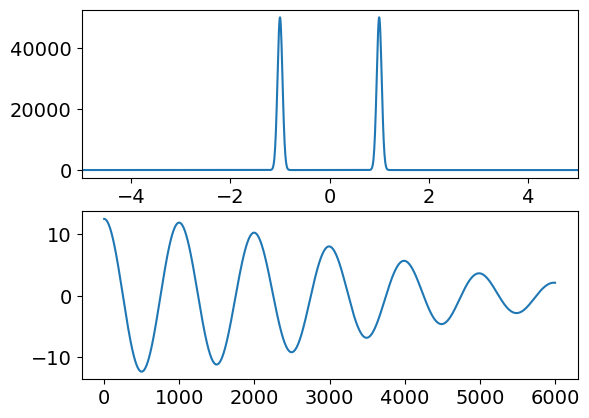

In [4]:
# Compute the minimum lambda0 for this CIF spectrum
psdbump = model.cif.compute_bump_spectra()[0]
acfbump = np.real_if_close(
            np.fft.ifft(np.fft.ifftshift(psdbump), axis=0)
          ) 
assert(np.all(np.isreal(acfbump)))

fig, axs = plt.subplots(2,1)
axs[0].plot(model.cif.frequencies,psdbump)
axs[0].set_xlim([-5,5])
axs[1].plot(acfbump[:len(ta)])

3*np.sqrt(acfbump[0]*FS)


In [5]:
# Simulate the CIF a bunch of times and compute the instantaneous variance, compare to computed
warnings.simplefilter('ignore', UserWarning)

cif_td = np.zeros([1000, model.cif.N])
for i in range(1000):
    cif_td[i,:] = model.cif._simulate_time_domain()[:,0]

print(FS*acfbump[0])
print(np.var(cif_td,axis=0))

/var/folders/d6/rb7c6y5j05d5tz19rl56_bhm0000gn/T/ipykernel_33817/2630716546.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  cif_td[i,:] = model.cif._simulate_time_domain()[:,0]


12533.141373155004
[12876.10605166 12876.81097563 12877.52786022 ... 11922.49938857
 11918.79518937 11915.12250703]


/Users/Emily/miniconda3/envs/filtered-point-process/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:1642: ComplexWarning: Casting complex values to real discards the imaginary part
  return interp_func(x, xp, fp, left, right)


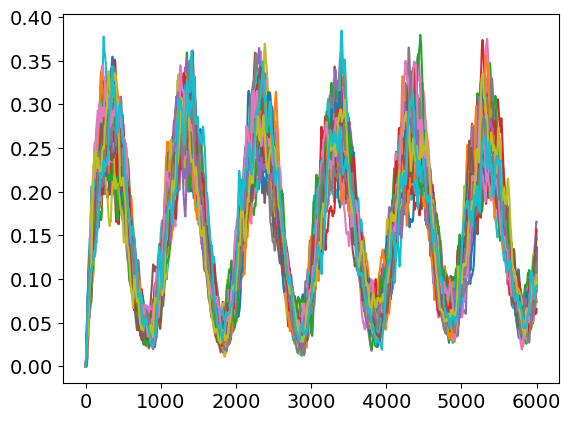

In [6]:
# Simulate the spikes a bunch of times

lfps_td = np.zeros([50, model.cif.N])
for i in range(50):
    model._simulate_process()
    fpp.apply_filter_sequences([["f1","f2"]], output_dir=None)
    tsi    = fpp.final_time_series_per_process[0]
    plt.plot(tsi)
    lfps_td[i,:] = tsi

# TODO: 
    # compute the spectra on the short time window used below
    # Plot the percentiles of the empirical spectra with the theo on top
    # look for spectral leakage throughout
    # Simulate filtered hom poisson with the mean lambda in the time window
    # plot the percentiles, look for spectral leakage
    # Check if linearly detrending the signal in the window helps

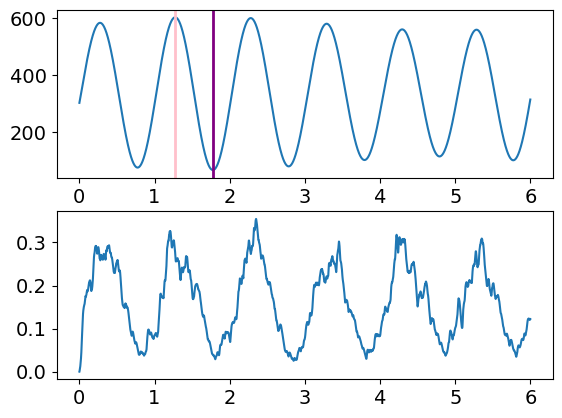

In [7]:
# ─── PICK SHORT TIMES ────────────────────────────────────
lam        = np.real(fpp.model.cif.cif_realization)

SHORT_TIMES  = [ta[np.argmin(lam)],ta[np.argmax(lam)]]

fig, axs = plt.subplots(2,1)
axs[0].plot(ta,lam)
axs[1].plot(ta,ts)
for t,c in zip(SHORT_TIMES, colors):
    axs[0].axvline(t, color=c, lw=2)


In [8]:
# ─── FULL-TRACE HANN-TAPER PSD ────────────────────────────────────
freqs_emp, psd_emp = sps.periodogram(ts, fs=FS, window='hann', scaling='density')
mask_emp       = (freqs_emp >= FMIN) & (freqs_emp <= FMAX)
fr_emp         = freqs_emp[mask_emp]
psd_emp_full   = psd_emp[mask_emp]

In [9]:
# ─── FULL-TRACE THEORETICAL SPECTRUM ──────────────────────────────
spec           = fpp.get_final_spectrum()
freqs_th       = fpp.model.frequencies
psd_th         = spec["final_total_spectrum"]
mask_th        = (freqs_th >= FMIN) & (freqs_th <= FMAX)
fr_th          = freqs_th[mask_th]
psd_th_full    = psd_th[mask_th]

In [10]:
# ─── WINDOWED HANN-TAPER SPECTROGRAM ──────────────────────────────
f_win, t_win, Sxx = sps.spectrogram(
    ts,
    fs=FS,
    window='hann',
    nperseg=int(WIN_DUR*FS),
    noverlap=int((WIN_DUR-WIN_STEP)*FS),
    scaling='density',
    mode='psd'
)
mask_win_full = (f_win >= FMIN) & (f_win <= FMAX)
fr_win        = f_win[mask_win_full]
psd_win_lin_m = Sxx[mask_win_full, :].T    # (n_windows × n_freq)
time_edges    = np.arange(psd_win_lin_m.shape[0] + 1) * WIN_STEP

# ─── INSTANTANEOUS RATE ───────────────────────────────────────────
time_axis  = fpp.model.time_axis
lam        = np.real(fpp.model.cif.cif_realization)
n_win      = psd_win_lin_m.shape[0]
win_centers = np.arange(n_win)*WIN_STEP + WIN_DUR/2
win_idx     = [np.argmin(np.abs(win_centers - t)) for t in SHORT_TIMES]
lam_idx     = [np.argmin(np.abs(time_axis   - t)) for t in SHORT_TIMES]

# ─── FILTER-ONLY SPECTRUM ─────────────────────────────────────────
H1            = fpp.filter_instances['f1'].kernel_spectrum
H2            = fpp.filter_instances['f2'].kernel_spectrum
Htot_emp_full = H1 * H2
# on full PSD grid:
Htot_emp = np.interp(fr_emp, freqs_th, Htot_emp_full)
# on windowed grid:
Htot_win = np.interp(fr_win, freqs_th, Htot_emp_full)

# ─── THEORETICAL SPECTROGRAM (dB) ─────────────────────────────────
spec_th      = np.outer(lam, Htot_emp)
spec_th_dB   = 10 * np.log10(spec_th)
vmin2, vmax2 = np.percentile(spec_th_dB, [1,99])

# ─── EMPIRICAL SPECTROGRAM (dB) ──────────────────────────────────
psd_win_dB   = 10 * np.log10(psd_win_lin_m)
vmin3, vmax3 = np.percentile(psd_win_dB, [1,99])

In [11]:
# ─── FITTED LAMBDA ──────────────────────────────────
warnings.simplefilter('ignore', DomainWarning)

FLIMS_FIT = [10,100]
fmask_fit = np.bitwise_and(fr_win>FLIMS_FIT[0],fr_win<FLIMS_FIT[1])
X = Htot_win[fmask_fit]  # Theoretical PSD as predictor

n_windows = len(t_win)

lambda0_hat = np.zeros(n_windows)
k_hat = np.zeros(n_windows)
for i in range(n_windows):
    y = psd_win_lin_m[i,fmask_fit]              # Empirical PSD as response

    glm_model = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.identity()))
    glm_results = glm_model.fit()

    lambda0_hat[i] = glm_results.params[0]
    phi = glm_results.scale
    k_hat[i] = 1 / phi

/Users/Emily/miniconda3/envs/filtered-point-process/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(


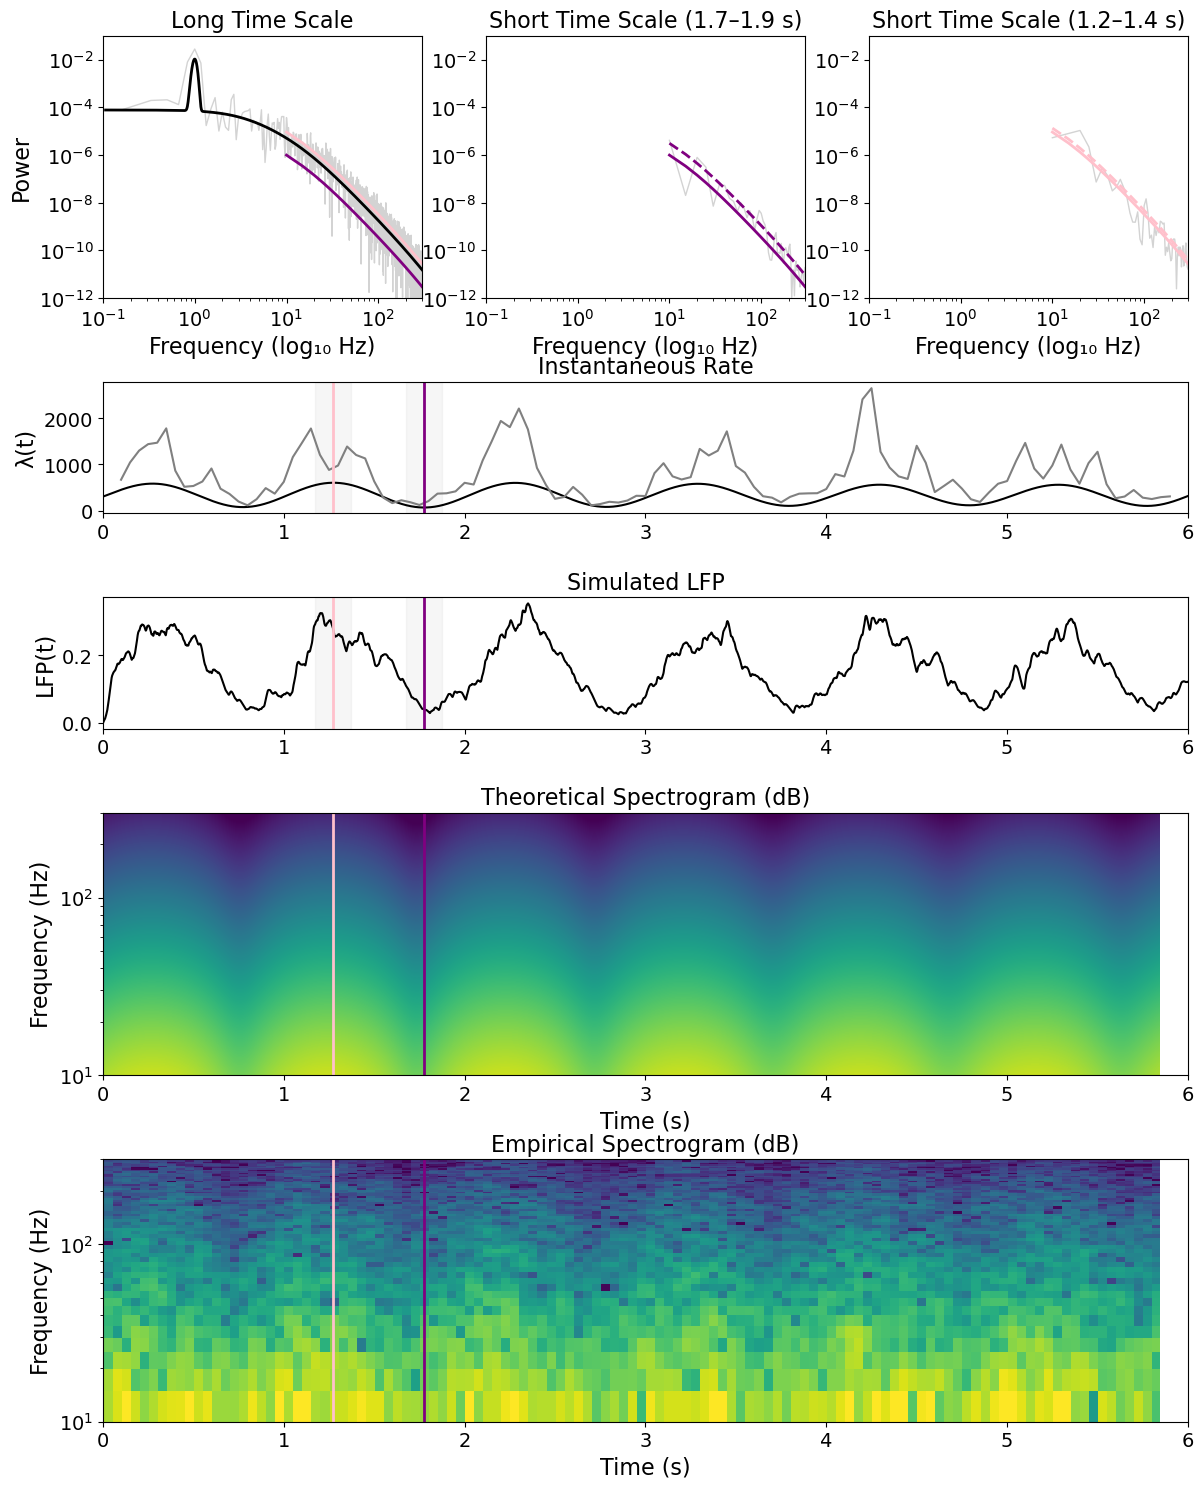

In [12]:
# ─── MULTI-PANEL PLOT ─────────────────────────────────────────────
fig = plt.figure(figsize=(14,18))
gs  = fig.add_gridspec(5, 3,
                       height_ratios=[1, 0.5, 0.5, 1, 1],
                       hspace=0.4)

# ─ Row 1A: Full PSD vs Theory ─────────────────────────────────────
ax1 = fig.add_subplot(gs[0,0])
ax1.loglog(fr_emp,   psd_emp_full, color='lightgrey', lw=1)
ax1.loglog(fr_th,    psd_th_full,  color='black',     lw=2)
ax1.set(xscale='log', yscale='log',
        xlim=(FMIN, FMAX), ylim=(ymin, ymax),
        title='Long Time Scale')
ax1.set_ylabel('Power')
ax1.set_xlabel('Frequency (log₁₀ Hz)')

# ─ Row 1B & 1C: Snapshots at SHORT_TIMES ─────────────────────────
for i, (t, widx, li) in enumerate(zip(SHORT_TIMES, win_idx, lam_idx), start=1):
    ax = fig.add_subplot(gs[0, i], sharex=ax1)
    mask_short    = fr_win >= 10
    freqs_short   = fr_win[mask_short]
    emp_short     = psd_win_lin_m[widx][mask_short]
    theo_full_win = lam[li] * Htot_win
    theo_short    = theo_full_win[mask_short]
    fit_full_win  = lambda0_hat[widx] * Htot_win
    fit_short     = fit_full_win[mask_short]

    ax.loglog(freqs_short, emp_short,  color='lightgrey', lw=1)
    ax.loglog(freqs_short, theo_short, color=colors[i-1],     lw=2)
    ax.loglog(freqs_short, fit_short, color=colors[i-1],     lw=2, linestyle='--')
    ax.set(xscale='log', yscale='log',
           xlim=(FMIN, FMAX), ylim=(ymin, ymax),
           title=f"Short Time Scale ({t-WIN_DUR/2:.1f}–{t+WIN_DUR/2:.1f} s)")
    ax.set_xlabel('Frequency (log₁₀ Hz)')

    ax1.loglog(freqs_short, theo_short, color=colors[i-1],     lw=2)

# ─ Row 2: λ(t) over first 5 s ───────────────────────────────────
axλ = fig.add_subplot(gs[1, :])
axλ.plot(time_axis, lam, lw=1.5, color='black')
axλ.plot(t_win, lambda0_hat, lw=1.5, color='grey')
axλ.set(xlim=(0, DURATION), ylabel='λ(t)', title='Instantaneous Rate')
for t,c in zip(SHORT_TIMES, colors):
    axλ.axvline(t, color=c, lw=2)
axλ.axvspan(SHORT_TIMES[0]-WIN_DUR/2, SHORT_TIMES[0]+WIN_DUR/2,
            color='lightgrey', alpha=0.2)
axλ.axvspan(SHORT_TIMES[1]-WIN_DUR/2, SHORT_TIMES[1]+WIN_DUR/2,
            color='lightgrey', alpha=0.2)

# ─ Row 2: simulated data over first 5 s ───────────────────────────────────
ax1b = fig.add_subplot(gs[2, :])
ax1b.plot(time_axis, ts, lw=1.5, color='black')
ax1b.set(xlim=(0, DURATION), ylabel='LFP(t)', title='Simulated LFP')
for t,c in zip(SHORT_TIMES, colors):
    ax1b.axvline(t, color=c, lw=2)
ax1b.axvspan(SHORT_TIMES[0]-WIN_DUR/2, SHORT_TIMES[0]+WIN_DUR/2,
            color='lightgrey', alpha=0.2)
ax1b.axvspan(SHORT_TIMES[1]-WIN_DUR/2, SHORT_TIMES[1]+WIN_DUR/2,
            color='lightgrey', alpha=0.2)

# ─ Row 3: Theoretical Spectrogram ─────────────────────────────────
mask_spec        = fr_emp >= 10
fr_spec          = fr_emp[mask_spec]
spec_th_dB_mask  = spec_th_dB[:, mask_spec]

ax2 = fig.add_subplot(gs[3, :])
ax2.set_yscale('log')
pcm2 = ax2.imshow(
    spec_th_dB_mask.T,                    # data array (rows → freqs, cols → times)
    origin='lower',                       # put lowest freq at bottom
    aspect='auto',                        # allow independent axis scaling
    extent=[
        time_edges[0], time_edges[-1],    # t_min, t_max
        fr_spec[0],    fr_spec[-1]        # f_min, f_max
    ],
    cmap='viridis',
    vmin=vmin2,
    vmax=vmax2
)

for t,c in zip(SHORT_TIMES, colors):
    ax2.axvline(t, color=c, lw=2)
ax2.set(xlabel='Time (s)', ylabel='Frequency (Hz)',
        title='Theoretical Spectrogram (dB)',
        xlim=(0, DURATION), ylim=(10, FMAX))

# ─ Row 4: Empirical Spectrogram ──────────────────────────────────
mask_spec_emp      = fr_win >= 10
fr_spec_emp        = fr_win[mask_spec_emp]
psd_win_dB_masked  = psd_win_dB[:, mask_spec_emp]

ax3 = fig.add_subplot(gs[4, :])
ax3.set_yscale('log')
pcm3 = ax3.imshow(
    psd_win_dB_masked.T,                 
    origin='lower',
    aspect='auto',
    extent=[
        time_edges[0],     time_edges[-1],     
        fr_spec_emp[0],    fr_spec_emp[-1]     
    ],
    cmap='viridis',
    vmin=vmin3,
    vmax=vmax3
)

for t,c in zip(SHORT_TIMES, colors):
    ax3.axvline(t, color=c, lw=2)
ax3.set(xlabel='Time (s)', ylabel='Frequency (Hz)',
        title='Empirical Spectrogram (dB)',
        xlim=(0, DURATION), ylim=(10, FMAX))

plt.tight_layout()
plt.show()

# ─── SAVE FIGURES ─────────────────────────────────────────────────
root = "."
outdir = f"{root}/filtered-point-process/examples/"
os.makedirs(outdir, exist_ok=True)
fig.savefig(os.path.join(outdir, "Flow_chart.svg"), format="svg")
fig.savefig(os.path.join(outdir, "Flow_chart.png"), format="png", dpi=300)